In [1]:
# !pip install tabulate
# !pip install pytest tabulate hypothesis pandas matplotlib

import subprocess
import json
import os
import re
import time
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
metadata = []
with open("bug_portfolio/metadata.jsonl", "r") as f:
    buffer = ""
    for line in f:
        line = line.strip()
        if not line:
            continue
        buffer += line
        if line.endswith("}"):
            try:
                metadata.append(json.loads(buffer))
            except json.JSONDecodeError:
                pass
            buffer = ""

bug_map = {item["name"]: item.get("bug_description", "No description provided") for item in metadata}
functions = [item["name"] for item in metadata]

# Create mapping from function name to bug description
bug_map = {item["name"]: item.get("bug_description", "No description provided") for item in metadata}
functions = [item["name"] for item in metadata]

print(functions)
print(len(functions))

['set_Right_most_Unset_Bit', 'find_Max', 'get_max_gold', 'sumofFactors', 'first_Digit', 'find_max_val', 'bitonic_subsequence', 'binomial_Coeff', 'max_chain_length', 'sum_Of_Primes', 'max_run_uppercase', 'sort_by_dnf', 'pass_validity', 'check_Type_Of_Triangle', 'count_Pairs', 'generate_matrix', 'rgb_to_hsv', 'max_sub_array_sum', 'get_sum', 'count_duplic', 'is_subset', 'find_first_occurrence', 'longest_increasing_subsequence', 'sum_of_odd_Factors', 'find_longest_conseq_subseq', 'get_Number', 'Sum', 'get_median', 'largest_subset', 'armstrong_number']
30


In [3]:
def parse_counts_from_output(out):
    """Return (passed, failed) parsed from pytest stdout."""
    passed = 0
    failed = 0
    m_passed = re.search(r"(\d+)\s+passed", out)
    m_failed = re.search(r"(\d+)\s+failed", out)
    if m_passed:
        passed = int(m_passed.group(1))
    if m_failed:
        failed = int(m_failed.group(1))
    return passed, failed


def run_tests(file):
    """
    Run pytest on a single file.
    Returns:
        exitcode, passed, failed, time_taken_seconds, stdout, stderr
    """
    base = os.path.splitext(os.path.basename(file))[0]
    json_file = f"report_{base}.json"

    # ---- attempt 1: with JSON ----
    start = time.perf_counter()

    cmd = ["pytest", "-q", file, "--json-report", f"--json-report-file={json_file}"]
    proc = subprocess.run(cmd, capture_output=True, text=True)

    time_taken = time.perf_counter() - start

    # If pytest did not generate JSON or errored out → fallback
    if proc.returncode == 4 or not os.path.exists(json_file):
        # ---- fallback: run WITHOUT json-report ----
        start = time.perf_counter()

        fallback_cmd = ["pytest", "-q", file]
        proc2 = subprocess.run(fallback_cmd, capture_output=True, text=True)

        time_taken = time.perf_counter() - start

        passed, failed = parse_counts_from_output(proc2.stdout)
        return proc2.returncode, passed, failed, time_taken, proc2.stdout, proc2.stderr

    # ---- JSON successfully created: extract summary ----
    try:
        with open(json_file, "r", encoding="utf-8") as f:
            data = json.load(f)
        summary = data.get("summary", {})
        passed = summary.get("passed", 0)
        failed = summary.get("failed", 0)
    except Exception:
        # fallback to parsing stdout
        passed, failed = parse_counts_from_output(proc.stdout)
    finally:
        try:
            os.remove(json_file)
        except OSError:
            pass

    return proc.returncode, passed, failed, time_taken, proc.stdout, proc.stderr


In [4]:
llm_found = {}
human_found = {}

for func in functions:
    print(f"\n=== Testing `{func}` ===")
    print(f"Bug Description: {bug_map[func]}")

    # LLM tests
    llm_file = f"llm_tests/generated_tests/test_{func}.py"
    llm_exitcode, llm_passed, llm_failed, llm_time, llm_out, llm_err = run_tests(llm_file)

    llm_status = "found" if llm_exitcode != 0 else "not found"
    llm_found[func] = (llm_exitcode != 0)
    print(f"LLM tests for `{func}`: Bug {llm_status} (exit code {llm_exitcode})")
    print(f"LLM Summary: {llm_passed} passed, {llm_failed} failed (time: {llm_time:.2f}s)")

    # Human tests
    human_file = f"human_tests/test_{func}.py"
    human_exitcode, human_passed, human_failed, human_time, human_out, human_err = run_tests(human_file)

    human_status = "found" if human_exitcode != 0 else "not found"
    human_found[func] = (human_exitcode != 0)
    print(f"Human tests for `{func}`: Bug {human_status} (exit code {human_exitcode})")
    print(f"Human Summary: {human_passed} passed, {human_failed} failed (time: {human_time:.2f}s)")



=== Testing `set_Right_most_Unset_Bit` ===
Bug Description: When n = 0, the function returns 0 instead of 1
LLM tests for `set_Right_most_Unset_Bit`: Bug found (exit code 1)
LLM Summary: 12 passed, 1 failed (time: 2.15s)
Human tests for `set_Right_most_Unset_Bit`: Bug found (exit code 1)
Human Summary: 3 passed, 2 failed (time: 2.86s)

=== Testing `find_Max` ===
Bug Description: the condition if (arr[low] >= arr[mid]) should be if (arr[low] > arr[mid]), as using >= can cause incorrect recursion and miss the maximum element in certain cases.
LLM tests for `find_Max`: Bug not found (exit code 0)
LLM Summary: 10 passed, 0 failed (time: 1.93s)
Human tests for `find_Max`: Bug found (exit code 1)
Human Summary: 2 passed, 3 failed (time: 3.08s)

=== Testing `get_max_gold` ===
Bug Description: The final answer calculation loop doesn't check for the last row's first element. ie loop is running till m-2
LLM tests for `get_max_gold`: Bug found (exit code 1)
LLM Summary: 7 passed, 2 failed (time:

In [5]:
results = []
for func in functions:
    results.append({
        "Function": func,
        "LLM Found": "Yes" if llm_found.get(func, False) else "No",
        "Human Found": "Yes" if human_found.get(func, False) else "No"
    })

df = pd.DataFrame(results)



# Manually update any function’s results here:
# df.loc[df['Function'] == 'gold_mine_problem', 'LLM Found'] = 'No'
# df.loc[df['Function'] == 'set_Right_most_Unset_Bit', 'Human Found'] = 'Yes'
# Uncomment and edit as needed

# ---- Manual overrides go here ----
# df.loc[df['Function'] == 'gold_mine_problem', 'LLM Found'] = 'No'
# df.loc[df['Function'] == 'set_Right_most_Unset_Bit', 'Human Found'] = 'Yes'
# ----------------------------------

print("### Individual Test Results\n")
print(df.to_markdown(index=False))

### Individual Test Results

| Function                       | LLM Found   | Human Found   |
|:-------------------------------|:------------|:--------------|
| set_Right_most_Unset_Bit       | Yes         | Yes           |
| find_Max                       | No          | Yes           |
| get_max_gold                   | Yes         | Yes           |
| sumofFactors                   | Yes         | Yes           |
| first_Digit                    | No          | Yes           |
| find_max_val                   | No          | No            |
| bitonic_subsequence            | Yes         | No            |
| binomial_Coeff                 | Yes         | Yes           |
| max_chain_length               | No          | No            |
| sum_Of_Primes                  | No          | Yes           |
| max_run_uppercase              | Yes         | Yes           |
| sort_by_dnf                    | No          | Yes           |
| pass_validity                  | Yes         | Yes         

In [6]:
only_llm = ((df["LLM Found"] == "Yes") & (df["Human Found"] == "No")).sum()
only_human = ((df["LLM Found"] == "No") & (df["Human Found"] == "Yes")).sum()
both = ((df["LLM Found"] == "Yes") & (df["Human Found"] == "Yes")).sum()
neither = ((df["LLM Found"] == "No") & (df["Human Found"] == "No")).sum()

total = len(df)

# Overall detection percentages
llm_total_found = only_llm + both
human_total_found = only_human + both

llm_overall_percentage = round((llm_total_found / total) * 100, 2)
human_overall_percentage = round((human_total_found / total) * 100, 2)

scorecard = pd.DataFrame({
    "Metric": [
        "Bugs found only by LLM tests",
        "Bugs found only by Human properties",
        "Bugs found by both",
        "Bugs found by neither"
    ],
    "Count": [only_llm, only_human, both, neither],
})

# Add percentage column
scorecard["Percentage"] = (scorecard["Count"] / total * 100).round(2).astype(str) + "%"

print("\n\n### Final Scorecard\n")
print(scorecard.to_markdown(index=False))

print("\n### Overall Detection Rates\n")
print(f"LLM Overall Detection: {llm_total_found}/{total} = {llm_overall_percentage}%")
print(f"Human Overall Detection: {human_total_found}/{total} = {human_overall_percentage}%")

# Save CSVs
df.to_csv("results_summary.csv", index=False)
scorecard.to_csv("final_scorecard.csv", index=False)




### Final Scorecard

| Metric                              |   Count | Percentage   |
|:------------------------------------|--------:|:-------------|
| Bugs found only by LLM tests        |       2 | 6.67%        |
| Bugs found only by Human properties |       5 | 16.67%       |
| Bugs found by both                  |      19 | 63.33%       |
| Bugs found by neither               |       4 | 13.33%       |

### Overall Detection Rates

LLM Overall Detection: 21/30 = 70.0%
Human Overall Detection: 24/30 = 80.0%


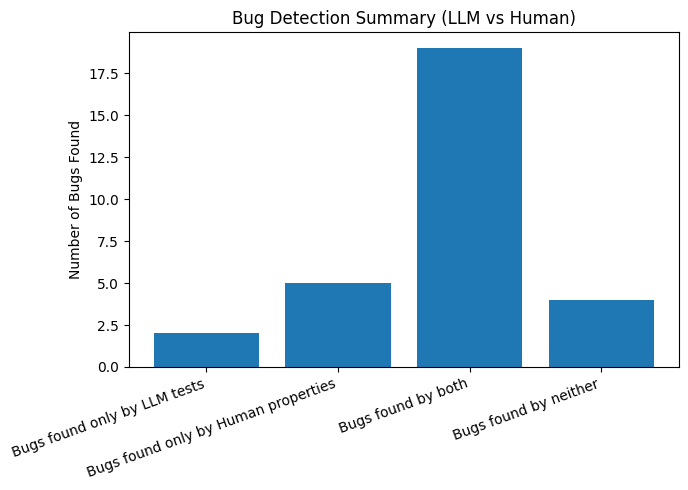

In [7]:
plt.figure(figsize=(7,5))
plt.bar(scorecard["Metric"], scorecard["Count"])
plt.title("Bug Detection Summary (LLM vs Human)")
plt.ylabel("Number of Bugs Found")
plt.xticks(rotation=20, ha='right')
plt.tight_layout()
plt.show()

# High-level summary

* Total functions tested: **30**
* Bugs found by **LLM tests**: **21**
* Bugs found by **Human tests**: **24**
* Found by **both**: **19**
* Found by **neither**: **4**
* LLM tests were consistently **faster** (shorter aggregate run times), humans typically took longer per case.


# Critical commentary - patterns, why each method succeeded or failed

### Where LLM tests tended to **succeed**

* **Systematic/templated edge cases and common off-by-one errors.**
  Examples: `count_duplic`, `get_sum`, `max_sub_array_sum`, `count_Pairs`, `generate_matrix`. These bugs are often revealed by small, mechanical edge tests (zero, one, two, exact-square, equal-values) - LLM test generators often include such cases automatically.
* **Simple arithmetic and indexing boundary checks.**
  LLMs found many faults that manifest with clear numerical boundaries or obvious loop limits.
* **Regular/structured problems where many known test patterns exist.**
  Algorithms with well-known failure modes (e.g., DP index updates, divisor loops) were frequently covered.

**Why LLM failed sometimes**

* **Missed subtle semantic conditions or rare invariants.**
  Missed `find_Max` (>= vs > in recursion) and `first_Digit` (loop stopping at 10) - these require thinking about exact mathematical invariants or particular small exceptions.
* **Errors that require understanding algorithmic intent or path-sensitive reasoning.**
  Example: `sum_Of_Primes` and `sum_of_odd_Factors` — deciding whether to include the `p * p == n` case or how to handle the last prime factor needs human-like reasoning about number theory edge cases.
* **Logic that depends on contextual ordering or non-obvious preconditions.**
  `sort_by_dnf` (mid += 2 bug) — a very specific mutation that a general test generator may not provoke without a tailored input.

### Where Human tests tended to **succeed**

* **Non-trivial algorithmic invariants or conceptual conditions.**
  Humans found `find_Max`, `first_Digit`, `sum_Of_Primes`, `sum_of_odd_Factors`, `sort_by_dnf` — these require insight into the algorithm's intended mathematics or the rare edge-case behaviors that are easy to reason about but less likely to be produced randomly.
* **Ad hoc corner cases gleaned from reading the code.**
  Humans reading the code can target inputs that exercise particular branches (e.g., exact power-of-two, `n=2` special-case, equal elements in rotated arrays).
* **Semantic/intent bugs (wrong operator, wrong formula, wrong parameter).**
  Humans are good at seeing "this line looks suspicious" and crafting an input to expose it (e.g., wrong binomial parameters, wrong hue offset in `rgb_to_hsv`).

**Why Humans failed sometimes**

* **Limited test breadth and repetition.**
  Humans missed systematic patterns that require many variant inputs to expose (e.g., some indexing loops, lots of permutations).
* **Human oversight and fatigue.**
  Some mechanical off-by-one or many quickly-exercised edge cases were missed because humans don't exhaustively enumerate cases.
* **Some misses on randomized or combinatorial inputs.**
  LLM-generated suites sometimes covered more combinations than a human would hand-write in the same time.


# Representative examples mapped to patterns

* **Missed by LLM but found by humans (semantic subtleties):**

  * `find_Max` - comparison `>=` vs `>` (recursion/branching invariant).
  * `first_Digit` - loop boundary when `fact == 10`.
  * `sum_Of_Primes` / `sum_of_odd_Factors` - subtle number-theory termination conditions.
  * `sort_by_dnf` - unusual off-by-two mutation, needs a small crafted sequence.

* **Missed by humans but found by LLM (systematic edge cases / many permutations):**

  * `bitonic_subsequence` - LIS strict vs non-strict inequality variants across many sequences.
  * `is_subset` - loop start index error (0 vs 1) that a generated battery of small sets exposes.
  * `find_longest_increasing_subsequence` - loop range bug (range start) that many random arrays will surface quickly.

* **Both caught (clear boundary / obviously wrong logic):**

  * `set_Right_most_Unset_Bit`, `get_max_gold`, `sumofFactors`, `pass_validity`, `check_Type_Of_Triangle`, many arithmetic/indexing errors - these are easily expressed and tested.

* **Neither caught (likely requires special inputs or semantic context):**

  * `find_max_val`, `max_chain_length`, `find_first_occurrence`, `find_longest_conseq_subseq` — either tests didn't include the precise corner inputs, or the bug requires deeper contextual understanding to design a revealing case.


# Conclusion - who “won” and practical takeaways

**Winner:** *Human testers* - narrowly.

* Humans found **24** bugs; LLM tests found **21**.
* However, the difference is small and *contextual*: humans found several deep/semantic bugs LLMs missed; LLMs found some systematic cases humans missed and did so faster.

**What each method is best at catching**

* **LLM / Automated test generators**

  * Great at: broad coverage, quickly producing many permutations and boundary tests; exposing mechanical off-by-one errors, missing equality/inequality conditions, indexing mistakes, and simple arithmetic edge cases.
  * Weak at: deep semantic invariants, math-based termination conditions, or tests that require reading intent and crafting highly specific inputs.

* **Human testers**

  * Great at: reasoning about algorithmic intent, noticing suspicious lines (wrong formula/parameter), and crafting sparse but precise inputs to expose semantic or logic-level errors.
  * Weak at: exhaustive combinatorial coverage and quickly generating many edge-case permutations - humans are slower and more error-prone for brute-force exploration.
